Connect to google drive

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Install OpenPose

In [20]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

Selecting previously unselected package libgflags2.2.
(Reading database ... 144429 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

In [2]:
!pip install opencv-python

Read input video (Change **FILEPATH** to the video you are going to use)

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import csv
import cv2

Input your own json folder path and your label csv file path here to './drive/My Drive/636/test/'

In [0]:
N_FACE = 70
N_POSE = 8
N_FEATURES = (N_FACE + N_POSE) * 2
MODEL_FOLDER = './drive/My Drive/636/model/'
JSON_FOLDER = './drive/My Drive/636/test/op_json/'
FOLDER = './drive/My Drive/636/test/'

COL_NAMES = ['frame']
COL_NAMES += ['f_' + str(i) for i in range(N_FACE * 2)]
COL_NAMES += ['p_' + str(i) for i in range(N_POSE * 2)]
droplist_f = set([(i * 3 + 2) for i in range(N_FACE)])
droplist_p = set([(i * 3 + 2) for i in range(N_POSE)])
idx_f = [i for i in range(N_FACE * 3) if (i not in droplist_f)]
idx_p = [i for i in range(N_POSE * 3) if (i not in droplist_p)]

In [0]:
# collect the json output of openpose and combine them into csv
def json_to_csv(folderpath, csv_path):
  idx = 0
  write_file = open(csv_path, 'w')
  csv_writer = csv.writer(write_file)
  csv_writer.writerow(COL_NAMES)
  for name in sorted(os.listdir(folderpath)): 
    if name[-4:] == 'json':
      filepath = os.path.join(folderpath, name)
      if os.path.isfile(filepath):
        with open(filepath, 'r') as f:
          data = json.load(f)['people']
          if len(data) > 0:
            row = [name]
            row_face = [float(data[0]['face_keypoints_2d'][j]) for j in idx_f]
            row_pose = [float(data[0]['pose_keypoints_2d'][j]) for j in idx_p]
            row += row_face + row_pose
            row = np.array(row)
            csv_writer.writerow(row)
      idx += 1

def get_csv(name):
  csv_path = FOLDER + name + '.csv'
  json_to_csv(JSON_FOLDER, csv_path)

Reshape Data into Segments and Prepare for Keras

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, TIME_STEP, fps):
  slices = []
  ts = []
  df = df[df.columns[1:]]
  for i in range(df.shape[0]):
    ts.append(i/fps)
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  ts_arr = np.asarray(ts, dtype= np.float32)
  return slices_arr, ts_arr

Load model and weight

In [7]:
%tensorflow_version 1.x
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, Activation, MaxPooling1D, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras.models import load_model

TensorFlow 1.x selected.


Using TensorFlow backend.


Draw figure

In [0]:
import matplotlib.pyplot as plt
from google.colab import files

def drawplt(time, pred, name):
  plt.figure(figsize=(10,8))
  plt.plot(time, pred, 'b', label='prediction', markersize=3, color='red')
  plt.title('Prediction over time')
  my_y_ticks = np.arange(0, 1.1, 0.1)
  plt.yticks(my_y_ticks)
  plt.legend()
  plt.savefig(name)

Generate json

In [0]:
def to_json(name, ts_arr, y_pred):
  np_pred = np.array((ts_arr, y_pred.flatten())).T
  pred_list = np_pred.tolist()
  pred_dict = {"cry":pred_list}
  pred_json = json.dumps(pred_dict)
  with open(name, 'w') as json_file:
    json_file.write(pred_json)

Detect poses on a test video

In [0]:
# YOUTUBE_ID = 'EsxSxC09KUU'
# NAME = '1200_2'

# YOUTUBE_ID = 'qNXn_kW6WtA'
# NAME = '1300_2'

# YOUTUBE_ID = 'jnGqAN6YOZ0'
# NAME = '1400_1'

# YOUTUBE_ID = 'PD8IWT3oa5s'
# NAME = '1500_1'

# YOUTUBE_ID = 't1u9_DHs4r4'
# NAME = '1600_1'

# YOUTUBE_ID = 'l3tnBOQG4zU'
# NAME = '1600_2'

# YOUTUBE_ID = 'uTbEdPzsXGo'
# NAME = '1600_3'

# YOUTUBE_ID = '0mc6IJd0NEw'
# NAME = '1600_4'

# YOUTUBE_ID = 'LqRJSNM814g'
# NAME = '1700_2'

# YOUTUBE_ID = 'IS3YZ9JSsnc'
# NAME = '1800_2'

# YOUTUBE_ID = 'UUtdMuT1EBU'
# NAME = '1900_2'

YOUTUBE_ID = 'NEkWx0pmzq4'
NAME = '2000_2'

In [153]:
!rm video.mp4
!youtube-dl -f 'bestvideo[ext=mp4]' --output "video.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

[youtube] NEkWx0pmzq4: Downloading webpage
[download] Destination: video.mp4
[download] 100% of 792.20KiB in 00:00


In [0]:
# def show_local_mp4_video(file_name, width=640, height=480):
#   import io
#   import base64
#   from IPython.display import HTML
#   video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
#   return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
#                         <source src="data:video/mp4;base64,{2}" type="video/mp4" />
#                       </video>'''.format(width, height, video_encoded.decode('ascii')))

# show_local_mp4_video('video.mp4', width=960, height=720)

Generate facial landmarks

In [0]:
%%shell
rm -r ./drive/My\ Drive/636/test/op_json/*
cd openpose
./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ../drive/My\ Drive/636/test/op_json --write_video ../drive/My\ Drive/636/test/2000_2.mp4 --number_people_max 1 --keypoint_scale 3 --display 0 --face

Get fps

In [0]:
videoCapture = cv2.VideoCapture("video.mp4")
fps = videoCapture.get(cv2.CAP_PROP_FPS)

**First_Automation_Part8**

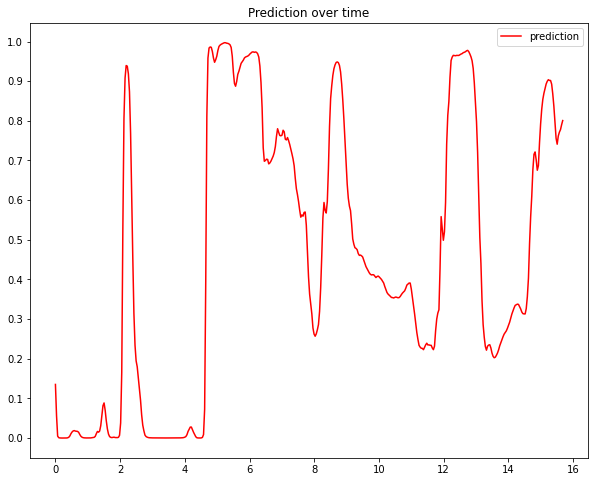

In [22]:
get_csv(NAME)
X = pd.read_csv(FOLDER + NAME + '.csv')
# load model
model = load_model(MODEL_FOLDER + 'part8/big_7859.h5')
# get input and timestep
frames = X.shape[0]
X_arr, ts_arr = get_slices(X, 10, fps)
# reshape input
X_arr4 = X_arr.reshape(X_arr.shape[0], 40, 39, 1)
# get prediction
y_pred = model.predict(X_arr4)
# draw plot
fig_name = FOLDER + NAME + '_Part8.png'
drawplt(ts_arr, y_pred, fig_name)
# output json file
js_name = FOLDER + NAME + '_Part8.json'
to_json(js_name, ts_arr, y_pred)

In [0]:
def get_pred(X, model, idx):
  # get prediction
  y_pred = model.predict(X)
  # draw plot
  fig_name = FOLDER + NAME + '_Part' + str(idx) + '.png'
  drawplt(ts_arr, y_pred, fig_name)
  # output json file
  js_name = FOLDER + NAME + '_Part' + str(idx) + '.json'
  to_json(js_name, ts_arr, y_pred)

**Automation_Part8**

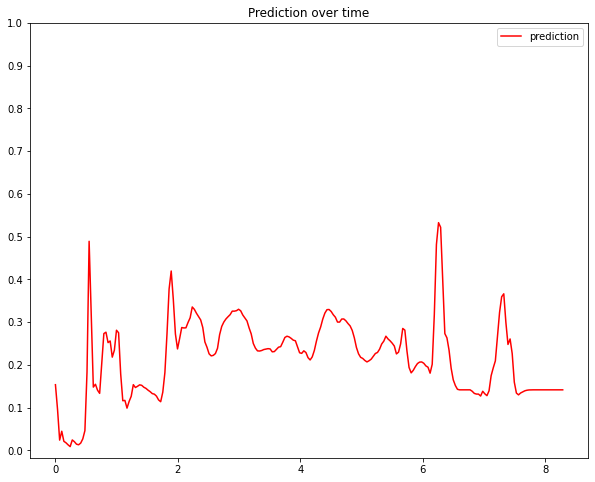

In [155]:
X = pd.read_csv(FOLDER + NAME + '.csv')
# load model
model = load_model(MODEL_FOLDER + 'part8/big_7859.h5')
# get input and timestep
X_arr, ts_arr = get_slices(X, 10, fps)
# reshape input
X_arr4 = X_arr.reshape(X_arr.shape[0], 40, 39, 1)
get_pred(X_arr4, model, 8)

**Automation_Part6**

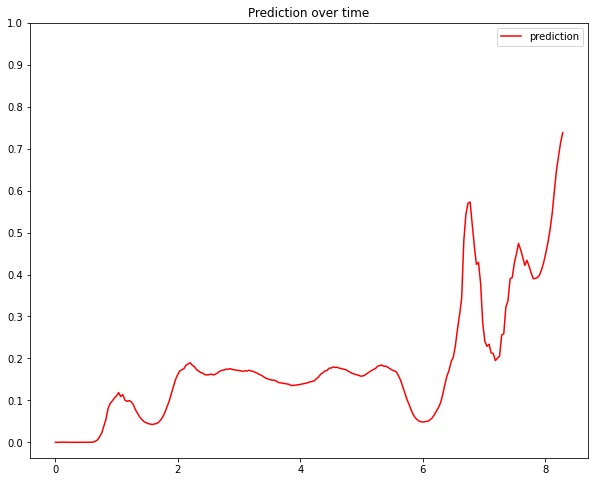

In [156]:
# load model
model = load_model(MODEL_FOLDER + 'model4_63.h5')
get_pred(X_arr, model, 61)

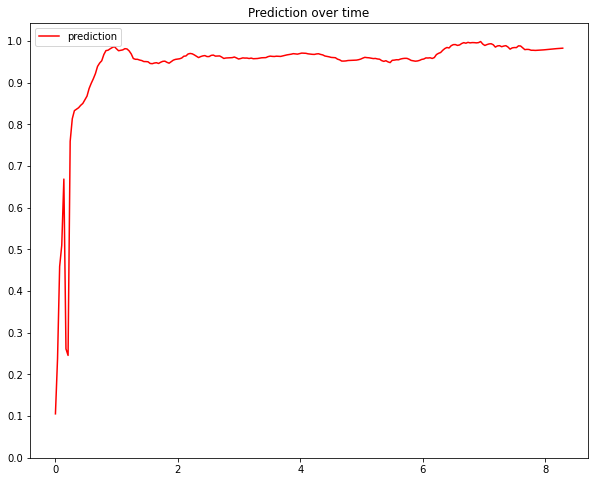

In [157]:
model = load_model(MODEL_FOLDER + 'model7_69.h5')
get_pred(X_arr, model, 62)

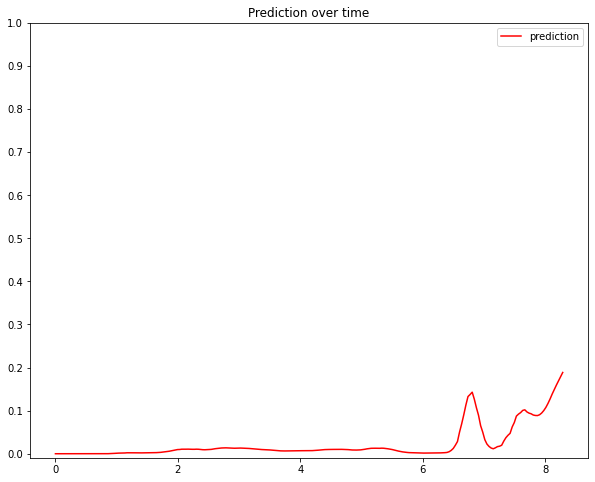

In [158]:
model = load_model(MODEL_FOLDER + 'model6_62.h5')
get_pred(X_arr, model, 63)

**Automation_Part5**

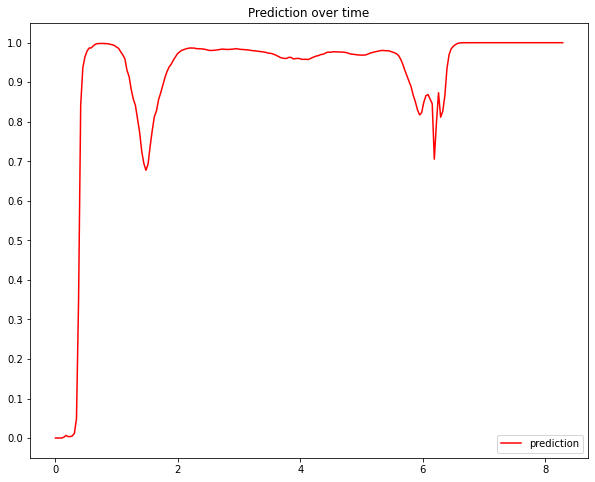

In [159]:
# load model
model = load_model(MODEL_FOLDER + 'bi_rmsprop.h5')
get_pred(X_arr, model, 51)

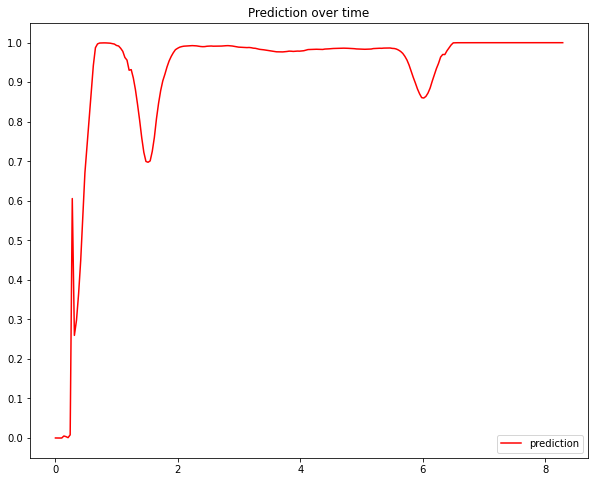

In [160]:
# load model
model = load_model(MODEL_FOLDER + 'bi_adam.h5')
get_pred(X_arr, model, 53)

PART4

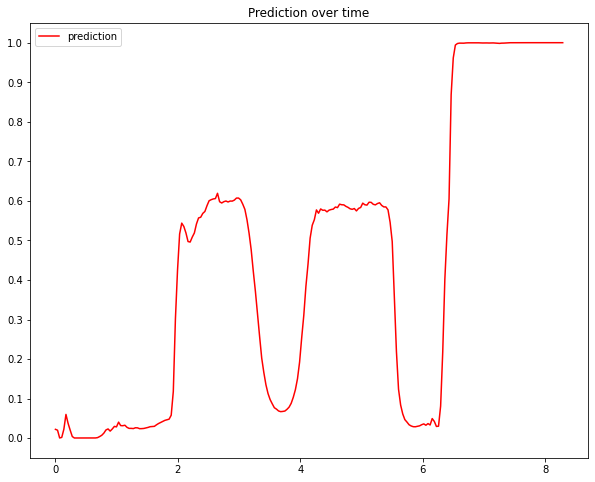

In [161]:
# load model
model = load_model(MODEL_FOLDER + 'origin_rmsprop.h5')
get_pred(X_arr, model, 4)